In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchmetrics.classification import BinaryAccuracy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet50
from sklearn.metrics import roc_curve, auc
import math
import os
from tqdm import tqdm

# Data Visualisation

In [3]:
data_path = 'Data/real_hst/'

In [4]:
lensing_images_paths = []
non_lensing_images_paths = []

# Iterate over files in the directory
for filename in os.listdir(data_path):
    file_path = os.path.join(data_path, filename)
    
    # Check if the file is a regular file (not a directory)
    if os.path.isfile(file_path):
        # Check the file naming format and append to the corresponding list
        if filename.endswith('_hst.npy') and not filename.startswith('nl_'):
            lensing_images_paths.append(file_path)
        elif filename.startswith('nl_') and filename.endswith('_hst.npy'):
            non_lensing_images_paths.append(file_path)

lensing_images_paths = np.array(lensing_images_paths, dtype=str)
non_lensing_images_paths = np.array(non_lensing_images_paths, dtype=str)

print("Number of lensing images are: ", len(lensing_images_paths))
print("Number of non-lensing images are: ", len(non_lensing_images_paths))

Number of lensing images are:  152
Number of non-lensing images are:  63


In [5]:
def display_images(images_paths, description):
    images = np.array([np.load(path) for path in images_paths])
    num_images = len(images)

    num_cols = math.ceil(math.sqrt(num_images))
    num_rows = math.floor(math.sqrt(num_images))

    if num_rows * num_cols < num_images:
        num_rows += 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))
    fig.suptitle(description)

    for img, ax in zip(images, axes.flatten()):
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    if num_images < num_rows * num_cols:
        for ax in axes.flatten()[num_images:]:
            ax.axis('off')

    plt.show()

In [6]:
num_images = 9
random_indices_1 = np.random.randint(0, len(lensing_images_paths), num_images)
random_indices_2 = np.random.randint(0, len(non_lensing_images_paths), num_images)

random_lensing_images_paths = lensing_images_paths[random_indices_1]
random_non_lensing_images_paths = non_lensing_images_paths[random_indices_2]

In [7]:
image = np.load(random_lensing_images_paths[0])
image.shape

(334, 334)

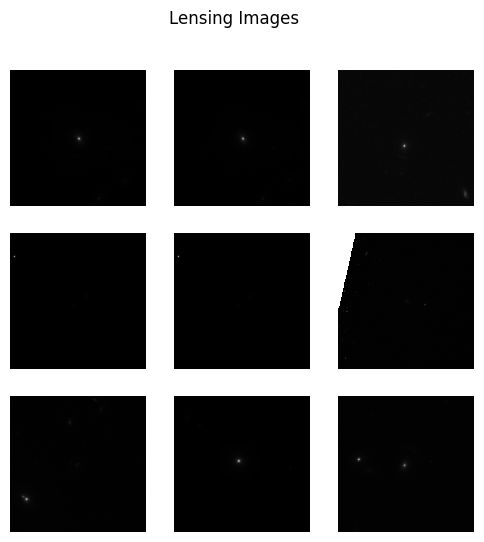

In [8]:
display_images(random_lensing_images_paths, description='Lensing Images')

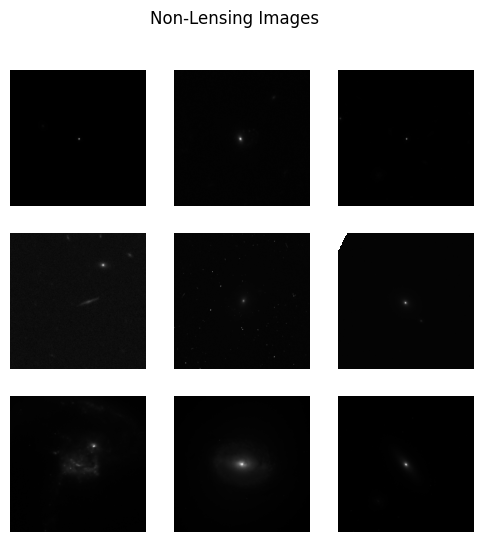

In [9]:
display_images(random_non_lensing_images_paths, description='Non-Lensing Images')

### While visualizing the data, we can see that some parts of the image are not rendered. This is because some values in the np array is `NaN`. To fix this, we can simply replace these pixels by `0`.

### Here is an example of an image which has `NaN` values. We will plot it before and after replacing with `0`

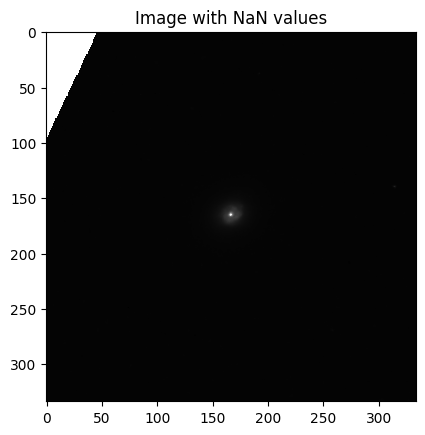

In [10]:
nan_image = np.load('Data/real_hst/nl_211_hst.npy')
plt.imshow(nan_image, cmap='gray')
plt.title('Image with NaN values')
plt.show()

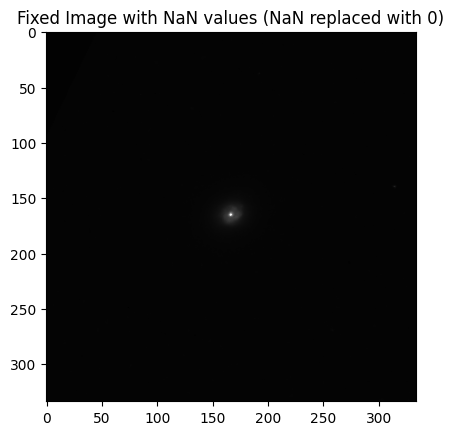

In [11]:
fixed_nan_image = np.nan_to_num(nan_image)
plt.imshow(fixed_nan_image, cmap='gray')
plt.title('Fixed Image with NaN values (NaN replaced with 0)')
plt.show()

# Dataclass
### This dataclass is common for all 3 solutions: `Baseline: Supervised learning with ResNet`, `Self supervised: Contrastive learning` and `Self supervised: SimSiam network`

### Since the number of datapoints is very less and I'm using a 90:10 split for training and validation sets, the number of datapoints in val set are only 20. The class imbalance is also high in the dataset.
### Due to this, even if the model always predicts the same class, validation accuracy can be a very high value (I was getting around 80% with random split) although the model is not learning anything.

### To fix this and get a more realistic validation accuracy, I have made sure that the number of datapoints for both classes are equal in the validation set. After making this change, an untrained model was giving 50% validation accuracy which is what we expect.

In [12]:
class LensingDataset(Dataset):
    def __init__(self, data_path, task='classification', split='train', rotation_augmentation=False):
        self.data_path = data_path
        self.task = task
        self.split = split
        self.rotation_augmentation = rotation_augmentation
        self.lensing_images, self.non_lensing_images = self.load_data()
        
        # converting NaN values to zeros
        self.lensing_images = np.nan_to_num(self.lensing_images)
        self.non_lensing_images = np.nan_to_num(self.non_lensing_images)
        
        self.images = np.concatenate([self.lensing_images, self.non_lensing_images], axis=0)
        self.labels = np.concatenate([np.ones(len(self.lensing_images)), np.zeros(len(self.non_lensing_images))], axis=0)

        self.images = self.scale_zero_to_one(self.images)
        
        self.images, self.labels = self.split_data(self.images, self.labels, self.split)

        # Only augment the train images
        if self.rotation_augmentation and self.split == 'train':
            self.images, self.labels = self.augment_rotation(self.images, self.labels)
        
        if self.task == 'classification':
            if self.split == 'train':
                self.class_weights = self.calculate_class_weights(self.labels)
            else:
                self.class_weights = None

        elif self.task == 'contrastive':
            self.lensing_indices = np.where(self.labels == 1)[0]
            self.non_lensing_indices = np.where(self.labels == 0)[0]

    def load_data(self):
        lensing_images_paths = []
        non_lensing_images_paths = []

        for filename in os.listdir(self.data_path):
            file_path = os.path.join(self.data_path, filename)
            
            if os.path.isfile(file_path):
                if filename.endswith('_hst.npy') and not filename.startswith('nl_'):
                    lensing_images_paths.append(file_path)
                elif filename.startswith('nl_') and filename.endswith('_hst.npy'):
                    non_lensing_images_paths.append(file_path)

        lensing_images_paths = np.array(lensing_images_paths, dtype=str)
        non_lensing_images_paths = np.array(non_lensing_images_paths, dtype=str)

        lensing_images = np.array([np.load(path)[np.newaxis, :, :] for path in lensing_images_paths])
        non_lensing_images = np.array([np.load(path)[np.newaxis, :, :] for path in non_lensing_images_paths])

        return lensing_images, non_lensing_images

    def scale_zero_to_one(self, images):
        mx = np.max(images)
        mn = np.min(images)

        return (images - mn) / (mx - mn)

    def augment_rotation(self, images, labels):
        augmented_images = []
        augmented_labels = []
        for img, lbl in zip(images, labels):
            for _ in range(4):
                augmented_images.append(np.rot90(img, k=_ , axes=(1, 2)))
                augmented_labels.append(lbl)

        return np.array(augmented_images), np.array(augmented_labels)
    
    def split_data(self, images, labels, split):
        lensing_indices = np.where(labels == 1)[0]
        non_lensing_indices = np.where(labels == 0)[0]
        
        size_val_set = int(0.1 * len(images))
        
        np.random.seed(42)
        np.random.shuffle(lensing_indices)
        np.random.shuffle(non_lensing_indices)
        
        if split == 'train':
            # Take the remaining elements for the training set
            train_lensing_indices = lensing_indices[size_val_set // 2:]
            train_non_lensing_indices = non_lensing_indices[size_val_set // 2:]
            train_indices = np.concatenate([train_lensing_indices, train_non_lensing_indices])
            return images[train_indices], labels[train_indices]
        elif split == 'val':
            # Take the first size_val_set/2 elements from each class for the validation set
            val_lensing_indices = lensing_indices[:size_val_set // 2]
            val_non_lensing_indices = non_lensing_indices[:size_val_set // 2]
            val_indices = np.concatenate([val_lensing_indices, val_non_lensing_indices])
            return images[val_indices], labels[val_indices]
        else:
            print("Please choose a valid split ('train' or 'val')")
            return None, None

    def calculate_class_weights(self, labels):
        num_samples_class0 = len(np.where(labels == 0)[0])
        num_samples_class1 = len(np.where(labels == 1)[0])
        total_samples = num_samples_class0 + num_samples_class1
        
        class_weight_class0 = total_samples / (2 * num_samples_class0)
        class_weight_class1 = total_samples / (2 * num_samples_class1)
        
        class_weights = torch.tensor([class_weight_class0, class_weight_class1])
        return class_weights

    def simsiam_transform(self, image):
        p_blur = 0.5 if image.shape[1] > 32 else 0  # exclude cifar
        
        transform = transforms.Compose([
            transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),
            transforms.ToPILImage(),
            transforms.Lambda(lambda x: x.convert('L')),  # Convert to grayscale mode 'L'
            transforms.Lambda(lambda x: x.convert('RGB')),  # Convert grayscale image to RGB
            transforms.RandomResizedCrop(image.shape[1], scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=image.shape[1]//20*2+1, sigma=(0.1, 2.0))], p=p_blur),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Adjust normalization based on your data
        ])
        
        return transform(image.squeeze(0))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.task == 'classification':
            return self.images[idx], self.labels[idx]
        
        elif self.task == 'contrastive':
            anchor_image = self.images[idx]
            anchor_label = self.labels[idx]
            
            if anchor_label == 1:
                positive_idx = np.random.choice(self.lensing_indices)
                negative_idx = np.random.choice(self.non_lensing_indices)
            else:
                positive_idx = np.random.choice(self.non_lensing_indices)
                negative_idx = np.random.choice(self.lensing_indices)
            
            positive_image = self.images[positive_idx]
            negative_image = self.images[negative_idx]
            
            return anchor_image, positive_image, negative_image
        
        elif self.task == 'simsiam':
            image = self.images[idx]
            image1 = self.simsiam_transform(image)
            image2 = self.simsiam_transform(image)
            return image1, image2

# Solution 1

# Baseline: Simple image classification with augmented (rotation) data using ResNet18 (Supervised learning)

In [27]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1, dropout_rate=0.5):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.dropout1(x)
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1, dropout_rate=0.5):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm1(self.conv1(x)))
    #   x = self.dropout1(x)
      
      x = self.batch_norm2(self.conv2(x))
    #   x = self.dropout2(x)

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
          
      x += identity
      x = self.relu(x)
      
      return x

class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=32)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=64, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=128, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=256, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256*ResBlock.expansion, num_classes)
        self.calculate_accuracy = BinaryAccuracy()
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

In [28]:
train_dataset = LensingDataset(data_path, split='train', rotation_augmentation=True)
val_dataset = LensingDataset(data_path, split='val', rotation_augmentation=True)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=10)

len(train_dataset), len(val_dataset)

(780, 20)

In [29]:
print("Number of ones in val_dataset.labels: ", np.sum(val_dataset.labels == 1))
print("Number of zeros in val_dataset.labels: " , np.sum(val_dataset.labels == 0))

print("Number of ones in train_dataset.labels: ", np.sum(train_dataset.labels == 1))
print("Number of zeros in train_dataset.labels: " , np.sum(train_dataset.labels == 0))

Number of ones in val_dataset.labels:  10
Number of zeros in val_dataset.labels:  10
Number of ones in train_dataset.labels:  568
Number of zeros in train_dataset.labels:  212


## Function to calculate ROC AUC value and plot the ROC curve (this function is used for all 3 solutions)

In [29]:
def calculate_and_plot_roc_auc(all_outputs, all_labels):
    """
    Input: 
    all_outputs: An array or tensor of model outputs with shape (N, C)
    all_labels: An array or tensor of labels with shape (N,)

    Return value:
    roc_auc: A float number representing the area under the ROC curve
    Plots the ROC curve
    """
    fpr, tpr, _ = roc_curve(all_labels, all_outputs)
    roc_auc = auc(fpr, tpr)
    
    print(f"ROC AUC: {roc_auc}")
    
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

## Training loop for ResNet Classifier

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet(ResBlock=Bottleneck, layer_list=[2, 2, 2, 2], num_classes=2, num_channels=1).to(device) 
# for a larger dataset, we can use a ResNet50 model just by changing the layer_list to [3, 4, 6, 3]
model_name = 'ResNet18'
lr = 0.01
criterion = nn.CrossEntropyLoss(weight=train_dataset.class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
best_val_acc = 0.0

epochs = 20

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels.long()
        loss = criterion(outputs, labels)
        accuracy = model.calculate_accuracy(outputs.argmax(dim=1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy
    print(f"Epoch {epoch+1}, Training loss: {running_loss/len(train_loader)}, Accuracy: {running_accuracy/len(train_loader)}")

    if (epoch + 1) % 1 == 0:
        model.eval()
        running_loss = 0.0
        running_accuracy = 0.0
        with torch.no_grad():
            for i, data in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                labels = labels.long()
                loss = criterion(outputs, labels)
                accuracy = model.calculate_accuracy(outputs.argmax(dim=1), labels)
                running_loss += loss.item()
                running_accuracy += accuracy
        val_acc = running_accuracy/len(val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'ckpts/baseline/{model_name}_{lr}.pth')
        print(f"Epoch {epoch+1}, Validation loss: {running_loss/len(val_loader)}, Accuracy: {running_accuracy/len(val_loader)}")

print("Best validation set accuracy is:", best_val_acc.item())
print('Finished Training')

100%|██████████| 98/98 [00:07<00:00, 12.27it/s]

Epoch 1, Training loss: 0.8669541608922335, Accuracy: 0.6658163070678711



100%|██████████| 3/3 [00:00<00:00,  9.70it/s]

Epoch 1, Validation loss: 0.6776158213615417, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:02<00:00, 34.68it/s]

Epoch 2, Training loss: 0.6823099757335624, Accuracy: 0.71683669090271



100%|██████████| 3/3 [00:00<00:00,  9.70it/s]

Epoch 2, Validation loss: 0.8055000305175781, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:02<00:00, 34.25it/s]

Epoch 3, Training loss: 0.6522698487554278, Accuracy: 0.7155612111091614



100%|██████████| 3/3 [00:00<00:00,  9.49it/s]

Epoch 3, Validation loss: 0.7214521567026774, Accuracy: 0.5



100%|██████████| 98/98 [00:02<00:00, 35.04it/s]

Epoch 4, Training loss: 0.657877582980662, Accuracy: 0.714285671710968



100%|██████████| 3/3 [00:00<00:00, 10.56it/s]

Epoch 4, Validation loss: 0.6443690856297811, Accuracy: 0.5833333730697632



100%|██████████| 98/98 [00:03<00:00, 32.40it/s]

Epoch 5, Training loss: 0.6638321511599482, Accuracy: 0.7181122303009033



100%|██████████| 3/3 [00:00<00:00, 10.47it/s]

Epoch 5, Validation loss: 0.8637450536092123, Accuracy: 0.5



100%|██████████| 98/98 [00:03<00:00, 32.41it/s]

Epoch 6, Training loss: 0.6592441698422238, Accuracy: 0.7193877696990967



100%|██████████| 3/3 [00:00<00:00, 10.83it/s]

Epoch 6, Validation loss: 0.7111313144365946, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:02<00:00, 33.32it/s]

Epoch 7, Training loss: 0.6482858802286946, Accuracy: 0.7283163070678711



100%|██████████| 3/3 [00:00<00:00, 10.63it/s]

Epoch 7, Validation loss: 0.6702922979990641, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:02<00:00, 33.80it/s]

Epoch 8, Training loss: 0.6481221938619808, Accuracy: 0.7117346525192261



100%|██████████| 3/3 [00:00<00:00, 10.78it/s]

Epoch 8, Validation loss: 0.5859138468901316, Accuracy: 0.6666666865348816



100%|██████████| 98/98 [00:02<00:00, 33.69it/s]

Epoch 9, Training loss: 0.6315679747839363, Accuracy: 0.7359693646430969



100%|██████████| 3/3 [00:00<00:00, 10.20it/s]

Epoch 9, Validation loss: 0.5714093645413717, Accuracy: 0.6666666865348816



100%|██████████| 98/98 [00:03<00:00, 32.52it/s]

Epoch 10, Training loss: 0.627957461135728, Accuracy: 0.7487244606018066



100%|██████████| 3/3 [00:00<00:00,  9.93it/s]

Epoch 10, Validation loss: 0.6653258701165518, Accuracy: 0.5833333730697632



100%|██████████| 98/98 [00:02<00:00, 34.30it/s]

Epoch 11, Training loss: 0.6357751382248742, Accuracy: 0.7423469424247742



100%|██████████| 3/3 [00:00<00:00, 11.18it/s]

Epoch 11, Validation loss: 0.817033569018046, Accuracy: 0.5



100%|██████████| 98/98 [00:02<00:00, 32.83it/s]

Epoch 12, Training loss: 0.6263648891935543, Accuracy: 0.7270408272743225



100%|██████████| 3/3 [00:00<00:00, 10.08it/s]

Epoch 12, Validation loss: 1.1084502736727397, Accuracy: 0.4166666865348816



100%|██████████| 98/98 [00:02<00:00, 34.33it/s]

Epoch 13, Training loss: 0.6078562941782328, Accuracy: 0.7423469424247742



100%|██████████| 3/3 [00:00<00:00,  9.54it/s]

Epoch 13, Validation loss: 0.5836780269940695, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:02<00:00, 33.24it/s]

Epoch 14, Training loss: 0.6434620561040177, Accuracy: 0.7270408272743225



100%|██████████| 3/3 [00:00<00:00, 11.29it/s]

Epoch 14, Validation loss: 0.6112044850985209, Accuracy: 0.4166666865348816



100%|██████████| 98/98 [00:02<00:00, 34.54it/s]

Epoch 15, Training loss: 0.6215230603607333, Accuracy: 0.7436224222183228



100%|██████████| 3/3 [00:00<00:00, 10.01it/s]

Epoch 15, Validation loss: 0.6354765097300211, Accuracy: 0.5833333730697632



100%|██████████| 98/98 [00:02<00:00, 32.83it/s]

Epoch 16, Training loss: 0.6168824552881474, Accuracy: 0.7372449040412903



100%|██████████| 3/3 [00:00<00:00,  9.40it/s]

Epoch 16, Validation loss: 0.5800112386544546, Accuracy: 0.5833333730697632



100%|██████████| 98/98 [00:03<00:00, 32.17it/s]

Epoch 17, Training loss: 0.6057817259309243, Accuracy: 0.7270408272743225



100%|██████████| 3/3 [00:00<00:00, 10.09it/s]

Epoch 17, Validation loss: 0.6715502242247263, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:02<00:00, 32.84it/s]

Epoch 18, Training loss: 0.6153142540430536, Accuracy: 0.7653061151504517



100%|██████████| 3/3 [00:00<00:00,  9.57it/s]

Epoch 18, Validation loss: 0.9520047605037689, Accuracy: 0.4583333432674408



100%|██████████| 98/98 [00:02<00:00, 33.30it/s]

Epoch 19, Training loss: 0.6068624519571966, Accuracy: 0.7627550959587097



100%|██████████| 3/3 [00:00<00:00, 10.64it/s]

Epoch 19, Validation loss: 0.6844547192255656, Accuracy: 0.5833333730697632



100%|██████████| 98/98 [00:02<00:00, 35.73it/s]

Epoch 20, Training loss: 0.6126095737729754, Accuracy: 0.7397959232330322



100%|██████████| 3/3 [00:00<00:00, 10.35it/s]

Epoch 20, Validation loss: 0.9135825236638387, Accuracy: 0.4583333432674408
Best validation set accuracy is: 0.6666666865348816
Finished Training


ROC AUC: 0.72


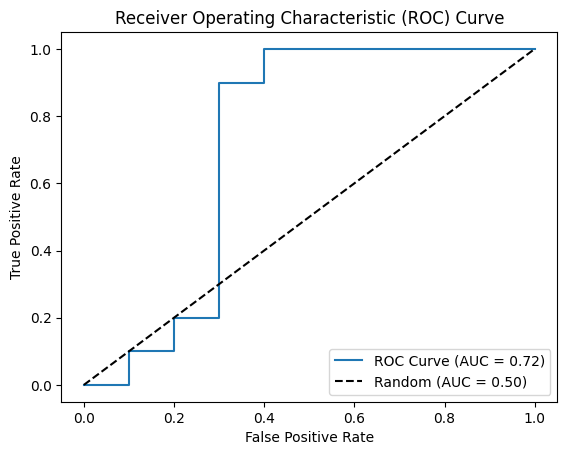

In [52]:
best_model_path = 'ckpts/baseline/ResNet18_0.01.pth'
model = ResNet(ResBlock=Bottleneck, layer_list=[2, 2, 2, 2], num_classes=2, num_channels=1).to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_outputs = []
all_labels = []
with torch.no_grad():
    for batch in val_loader:
        inputs = batch[0].to(device)
        all_outputs.extend(model(inputs).cpu().numpy())
        all_labels.extend(batch[1].numpy())

all_outputs = [output[1] for output in all_outputs]

roc_auc = calculate_and_plot_roc_auc(all_outputs, all_labels)

# Solution 2

# Unsupervised Learning approach: Contrastive learning
## In this technique, I first perform contrastive pretraining and then finetune it for classification

### While training, an image is taken as an anchor image and we randomly select a positive sample - another image which belongs to the same class as the anchor image. Along with this, we also randomly select a negative sample - which is another image which does not belong to the class of the anchor image.

### This technique is `not truly self supervised` since we use labels to create positive and negative samples

In [53]:
# There are no changes in the Bottleneck and the Block classes, I am just keeping them here for completeness
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1, dropout_rate=0.5):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.dropout1(x)
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1, dropout_rate=0.5):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm1(self.conv1(x)))
    #   x = self.dropout1(x)
      
      x = self.batch_norm2(self.conv2(x))
    #   x = self.dropout2(x)

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
          
      x += identity
      x = self.relu(x)
      
      return x

class ResNetContrastive(nn.Module):
    def __init__(self, ResBlock, layer_list, embedding_dim, num_channels=3, num_classes=2, task='pretraining'):
        super(ResNetContrastive, self).__init__()
        self.embedding_dim = embedding_dim
        self.task = task
        self.in_channels = 64
        if self.task == 'classification':
            self.num_classes = num_classes
        else:
            self.num_classes = None
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=32)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=64, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=128, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=256, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256*ResBlock.expansion, num_classes) # This will be used only when task is 'classification'

        self.projection_head = nn.Sequential(
            nn.Linear(256 * ResBlock.expansion, 256),
            nn.ReLU(),
            nn.Linear(256, self.embedding_dim),
        )

        self.calculate_accuracy = BinaryAccuracy()
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)

        if self.task == 'pretraining':
            x = self.projection_head(x)
            x = F.normalize(x, p=2, dim=1)
        elif self.task == 'classification':
            x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

In [54]:
train_dataset_contrastive = LensingDataset(data_path, split='train', rotation_augmentation=True, task='contrastive')
val_dataset_contrastive = LensingDataset(data_path, split='val', rotation_augmentation=True, task='contrastive')

train_loader_contrastive = DataLoader(train_dataset_contrastive, batch_size=8, shuffle=True, num_workers=10)
val_loader_contrastive = DataLoader(val_dataset_contrastive, batch_size=8, shuffle=False, num_workers=10)

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNetContrastive(ResBlock=Bottleneck, layer_list=[2, 2, 2, 2], embedding_dim=128, num_channels=1, num_classes=2, task='pretraining').to(device)
model_name = 'ResNet18_Contrastive'
lr = 0.01
criterion = nn.TripletMarginLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
best_val_loss = float('inf')

epochs = 50

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader_contrastive, 0), total=len(train_loader_contrastive)):
        anchor, positive, negative = data[0].to(device), data[1].to(device), data[2].to(device)

        anchor_embedding = model(anchor)
        positive_embedding = model(positive)
        negative_embedding = model(negative)

        loss = criterion(anchor_embedding, positive_embedding, negative_embedding)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Training loss: {running_loss/len(train_loader_contrastive)}")

    if (epoch + 1) % 1 == 0:
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for i, data in tqdm(enumerate(val_loader_contrastive, 0), total=len(val_loader_contrastive)):
                anchor, positive, negative = data[0].to(device), data[1].to(device), data[2].to(device)

                anchor_embedding = model(anchor)
                positive_embedding = model(positive)
                negative_embedding = model(negative)

                loss = criterion(anchor_embedding, positive_embedding, negative_embedding)

                running_loss += loss.item()

        val_loss = running_loss/len(val_loader_contrastive)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'ckpts/contrastive/pretraining/{model_name}_{lr}.pth')
        print(f"Epoch {epoch+1}, Validation loss: {running_loss/len(val_loader_contrastive)}")

print("Best validation set loss is:", best_val_loss)
print('Finished Training')

100%|██████████| 98/98 [00:06<00:00, 14.95it/s]

Epoch 1, Training loss: 0.9912552535533905



100%|██████████| 3/3 [00:00<00:00,  8.91it/s]

Epoch 1, Validation loss: 0.9808210134506226



100%|██████████| 98/98 [00:06<00:00, 14.96it/s]

Epoch 2, Training loss: 0.9567647728384757



100%|██████████| 3/3 [00:00<00:00,  8.46it/s]

Epoch 2, Validation loss: 0.7589208285013834



100%|██████████| 98/98 [00:06<00:00, 16.01it/s]

Epoch 3, Training loss: 0.9354821010207643



100%|██████████| 3/3 [00:00<00:00,  8.89it/s]

Epoch 3, Validation loss: 1.2803544600804646



100%|██████████| 98/98 [00:06<00:00, 15.03it/s]

Epoch 4, Training loss: 0.9919876121744817



100%|██████████| 3/3 [00:00<00:00,  7.95it/s]

Epoch 4, Validation loss: 1.154663860797882



100%|██████████| 98/98 [00:06<00:00, 15.62it/s]

Epoch 5, Training loss: 0.9342044233059397



100%|██████████| 3/3 [00:00<00:00, 13.05it/s]

Epoch 5, Validation loss: 0.867788145939509



100%|██████████| 98/98 [00:05<00:00, 16.76it/s]

Epoch 6, Training loss: 0.8581491150722211



100%|██████████| 3/3 [00:00<00:00,  7.37it/s]

Epoch 6, Validation loss: 1.0679477254549663



100%|██████████| 98/98 [00:06<00:00, 15.39it/s]

Epoch 7, Training loss: 0.957825322540439



100%|██████████| 3/3 [00:00<00:00,  7.53it/s]

Epoch 7, Validation loss: 1.0744883219401042



100%|██████████| 98/98 [00:06<00:00, 14.83it/s]

Epoch 8, Training loss: 0.91741651205384



100%|██████████| 3/3 [00:00<00:00,  8.62it/s]

Epoch 8, Validation loss: 1.0000919699668884



100%|██████████| 98/98 [00:06<00:00, 15.03it/s]

Epoch 9, Training loss: 0.9134315513834661



100%|██████████| 3/3 [00:00<00:00,  8.41it/s]

Epoch 9, Validation loss: 0.9654858311017355



100%|██████████| 98/98 [00:06<00:00, 16.14it/s]

Epoch 10, Training loss: 0.8462586602082058



100%|██████████| 3/3 [00:00<00:00,  8.02it/s]

Epoch 10, Validation loss: 1.000012954076131



100%|██████████| 98/98 [00:06<00:00, 15.21it/s]

Epoch 11, Training loss: 0.9257000569178133



100%|██████████| 3/3 [00:00<00:00,  7.95it/s]

Epoch 11, Validation loss: 1.2358519832293193



100%|██████████| 98/98 [00:06<00:00, 15.47it/s]

Epoch 12, Training loss: 0.906922772526741



100%|██████████| 3/3 [00:00<00:00,  9.10it/s]

Epoch 12, Validation loss: 0.8895297050476074



100%|██████████| 98/98 [00:06<00:00, 15.93it/s]

Epoch 13, Training loss: 0.8963353360185817



100%|██████████| 3/3 [00:00<00:00,  8.46it/s]

Epoch 13, Validation loss: 0.7559853891531626



100%|██████████| 98/98 [00:06<00:00, 15.70it/s]

Epoch 14, Training loss: 0.8823298705475671



100%|██████████| 3/3 [00:00<00:00,  8.65it/s]

Epoch 14, Validation loss: 0.9174389441808065



100%|██████████| 98/98 [00:06<00:00, 16.10it/s]

Epoch 15, Training loss: 0.8102943179558735



100%|██████████| 3/3 [00:00<00:00,  8.84it/s]

Epoch 15, Validation loss: 1.1698010961214702



100%|██████████| 98/98 [00:06<00:00, 15.15it/s]

Epoch 16, Training loss: 0.8556122691655645



100%|██████████| 3/3 [00:00<00:00,  7.71it/s]

Epoch 16, Validation loss: 1.0336446563402812



100%|██████████| 98/98 [00:06<00:00, 14.89it/s]

Epoch 17, Training loss: 0.8471114042462135



100%|██████████| 3/3 [00:00<00:00,  7.47it/s]

Epoch 17, Validation loss: 0.8830365737279257



100%|██████████| 98/98 [00:06<00:00, 15.82it/s]

Epoch 18, Training loss: 0.877454830675709



100%|██████████| 3/3 [00:00<00:00, 12.35it/s]

Epoch 18, Validation loss: 1.0001939137776692



100%|██████████| 98/98 [00:06<00:00, 16.15it/s]

Epoch 19, Training loss: 0.840575603198032



100%|██████████| 3/3 [00:00<00:00,  9.27it/s]

Epoch 19, Validation loss: 0.7276842594146729



100%|██████████| 98/98 [00:06<00:00, 15.28it/s]

Epoch 20, Training loss: 0.8264521135359394



100%|██████████| 3/3 [00:00<00:00,  9.20it/s]

Epoch 20, Validation loss: 1.0439891417821248



100%|██████████| 98/98 [00:06<00:00, 16.32it/s]

Epoch 21, Training loss: 0.8656540973758211



100%|██████████| 3/3 [00:00<00:00,  8.55it/s]

Epoch 21, Validation loss: 0.77617875734965



100%|██████████| 98/98 [00:06<00:00, 16.21it/s]

Epoch 22, Training loss: 0.8496203331314788



100%|██████████| 3/3 [00:00<00:00,  8.99it/s]

Epoch 22, Validation loss: 1.1054906249046326



100%|██████████| 98/98 [00:06<00:00, 16.14it/s]

Epoch 23, Training loss: 0.8014670060757472



100%|██████████| 3/3 [00:00<00:00,  8.81it/s]

Epoch 23, Validation loss: 1.0686673521995544



100%|██████████| 98/98 [00:06<00:00, 15.92it/s]

Epoch 24, Training loss: 0.7908582825745855



100%|██████████| 3/3 [00:00<00:00,  9.74it/s]

Epoch 24, Validation loss: 0.7281936357418696



100%|██████████| 98/98 [00:06<00:00, 15.68it/s]

Epoch 25, Training loss: 0.7101143055728504



100%|██████████| 3/3 [00:00<00:00,  8.79it/s]

Epoch 25, Validation loss: 0.913002590338389



100%|██████████| 98/98 [00:06<00:00, 16.09it/s]

Epoch 26, Training loss: 0.7318292853935641



100%|██████████| 3/3 [00:00<00:00,  7.69it/s]

Epoch 26, Validation loss: 1.0183378060658772



100%|██████████| 98/98 [00:06<00:00, 15.89it/s]

Epoch 27, Training loss: 0.759387590751356



100%|██████████| 3/3 [00:00<00:00,  9.52it/s]

Epoch 27, Validation loss: 0.6437855859597524



100%|██████████| 98/98 [00:06<00:00, 16.06it/s]

Epoch 28, Training loss: 0.7186512925795147



100%|██████████| 3/3 [00:00<00:00,  7.41it/s]

Epoch 28, Validation loss: 1.145792583624522



100%|██████████| 98/98 [00:06<00:00, 15.95it/s]

Epoch 29, Training loss: 0.7166105391723769



100%|██████████| 3/3 [00:00<00:00,  8.29it/s]

Epoch 29, Validation loss: 0.842552105585734



100%|██████████| 98/98 [00:06<00:00, 15.89it/s]

Epoch 30, Training loss: 0.742547156099154



100%|██████████| 3/3 [00:00<00:00,  9.15it/s]

Epoch 30, Validation loss: 0.9206723471482595



100%|██████████| 98/98 [00:06<00:00, 15.92it/s]

Epoch 31, Training loss: 0.698529916074203



100%|██████████| 3/3 [00:00<00:00,  8.25it/s]

Epoch 31, Validation loss: 0.9976810018221537



100%|██████████| 98/98 [00:06<00:00, 15.87it/s]

Epoch 32, Training loss: 0.6582809614435751



100%|██████████| 3/3 [00:00<00:00,  9.70it/s]

Epoch 32, Validation loss: 0.7568221092224121



100%|██████████| 98/98 [00:06<00:00, 15.94it/s]

Epoch 33, Training loss: 0.6790361616532413



100%|██████████| 3/3 [00:00<00:00,  8.51it/s]

Epoch 33, Validation loss: 1.1111799677213032



100%|██████████| 98/98 [00:06<00:00, 15.84it/s]

Epoch 34, Training loss: 0.6307973378927124



100%|██████████| 3/3 [00:00<00:00,  9.24it/s]

Epoch 34, Validation loss: 0.7744973500569662



100%|██████████| 98/98 [00:06<00:00, 16.01it/s]

Epoch 35, Training loss: 0.6849180099611379



100%|██████████| 3/3 [00:00<00:00,  8.05it/s]

Epoch 35, Validation loss: 0.7626536339521408



100%|██████████| 98/98 [00:06<00:00, 15.91it/s]

Epoch 36, Training loss: 0.6397669897699843



100%|██████████| 3/3 [00:00<00:00,  7.98it/s]

Epoch 36, Validation loss: 1.0816377401351929



100%|██████████| 98/98 [00:06<00:00, 16.13it/s]

Epoch 37, Training loss: 0.7345690482429096



100%|██████████| 3/3 [00:00<00:00,  8.20it/s]

Epoch 37, Validation loss: 1.4557178616523743



100%|██████████| 98/98 [00:06<00:00, 16.14it/s]

Epoch 38, Training loss: 0.7012948496457265



100%|██████████| 3/3 [00:00<00:00,  8.96it/s]

Epoch 38, Validation loss: 1.1870307723681133



100%|██████████| 98/98 [00:06<00:00, 15.82it/s]

Epoch 39, Training loss: 0.6232189289769348



100%|██████████| 3/3 [00:00<00:00,  8.52it/s]

Epoch 39, Validation loss: 1.2162465453147888



100%|██████████| 98/98 [00:06<00:00, 15.86it/s]

Epoch 40, Training loss: 0.668537228539282



100%|██████████| 3/3 [00:00<00:00,  8.85it/s]

Epoch 40, Validation loss: 1.0029313663641612



100%|██████████| 98/98 [00:06<00:00, 15.91it/s]

Epoch 41, Training loss: 0.6846133044787815



100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

Epoch 41, Validation loss: 0.9657212495803833



100%|██████████| 98/98 [00:06<00:00, 15.95it/s]

Epoch 42, Training loss: 0.7141673812756733



100%|██████████| 3/3 [00:00<00:00,  9.02it/s]

Epoch 42, Validation loss: 0.8928197125593821



100%|██████████| 98/98 [00:06<00:00, 15.80it/s]

Epoch 43, Training loss: 0.741849677295101



100%|██████████| 3/3 [00:00<00:00,  8.37it/s]

Epoch 43, Validation loss: 1.171539584795634



100%|██████████| 98/98 [00:06<00:00, 15.42it/s]

Epoch 44, Training loss: 0.7068946257385672



100%|██████████| 3/3 [00:00<00:00, 11.03it/s]

Epoch 44, Validation loss: 0.8059711207946142



100%|██████████| 98/98 [00:06<00:00, 16.21it/s]

Epoch 45, Training loss: 0.6373257062264851



100%|██████████| 3/3 [00:00<00:00, 11.76it/s]

Epoch 45, Validation loss: 0.9285655419031779



100%|██████████| 98/98 [00:05<00:00, 18.45it/s]

Epoch 46, Training loss: 0.6555046375308718



100%|██████████| 3/3 [00:00<00:00, 15.65it/s]

Epoch 46, Validation loss: 0.9964507271846136



100%|██████████| 98/98 [00:05<00:00, 16.51it/s]

Epoch 47, Training loss: 0.7104688607612435



100%|██████████| 3/3 [00:00<00:00,  9.16it/s]

Epoch 47, Validation loss: 0.8967436850070953



100%|██████████| 98/98 [00:06<00:00, 15.43it/s]

Epoch 48, Training loss: 0.5899247414603526



100%|██████████| 3/3 [00:00<00:00, 11.65it/s]

Epoch 48, Validation loss: 1.1153080463409424



100%|██████████| 98/98 [00:05<00:00, 17.51it/s]

Epoch 49, Training loss: 0.6994656238476841



100%|██████████| 3/3 [00:00<00:00, 12.46it/s]

Epoch 49, Validation loss: 0.8567729791005453



100%|██████████| 98/98 [00:06<00:00, 15.94it/s]

Epoch 50, Training loss: 0.7106630225874939



100%|██████████| 3/3 [00:00<00:00,  9.46it/s]

Epoch 50, Validation loss: 1.0328299800554912
Best validation set loss is: 0.6437855859597524
Finished Training


## Now, we can load the best checkpoint saved during pretraining and finetune the model for classification task

In [56]:
model = ResNetContrastive(ResBlock=Bottleneck, layer_list=[2, 2, 2, 2], num_channels=1, embedding_dim=128, num_classes=2, task='classification').to(device)
print(f"Using model: ckpts/contrastive/pretraining/{model_name}_{lr}_best.pth")
model.load_state_dict(torch.load(f'ckpts/contrastive/pretraining/{model_name}_{lr}_best.pth'))

train_dataset = LensingDataset(data_path, split='train', rotation_augmentation=True)
val_dataset = LensingDataset(data_path, split='val', rotation_augmentation=True)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=10)

Using model: ckpts/contrastive/pretraining/ResNet18_Contrastive_0.01_best.pth


In [57]:
model_name = 'ResNet18_finetuned'
lr = 0.001
criterion = nn.CrossEntropyLoss(weight=train_dataset.class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
best_val_acc = 0.0

epochs = 50

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels.long()
        loss = criterion(outputs, labels)
        accuracy = model.calculate_accuracy(outputs.argmax(dim=1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy
    print(f"Epoch {epoch+1}, Training loss: {running_loss/len(train_loader)}, Accuracy: {running_accuracy/len(train_loader)}")

    if (epoch + 1) % 1 == 0:
        model.eval()
        running_loss = 0.0
        running_accuracy = 0.0
        with torch.no_grad():
            for i, data in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                labels = labels.long()
                loss = criterion(outputs, labels)
                accuracy = model.calculate_accuracy(outputs.argmax(dim=1), labels)
                running_loss += loss.item()
                running_accuracy += accuracy
        val_acc = running_accuracy/len(val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'ckpts/contrastive/finetuning/{model_name}_{lr}.pth')
        print(f"Epoch {epoch+1}, Validation loss: {running_loss/len(val_loader)}, Accuracy: {running_accuracy/len(val_loader)}")

print("Best validation set accuracy is:", best_val_acc)
print('Finished Training')

100%|██████████| 98/98 [00:02<00:00, 34.85it/s]

Epoch 1, Training loss: 0.7318773352522023, Accuracy: 0.6632652878761292



100%|██████████| 3/3 [00:00<00:00,  9.44it/s]

Epoch 1, Validation loss: 0.9314519912004471, Accuracy: 0.5833333730697632



100%|██████████| 98/98 [00:03<00:00, 30.94it/s]

Epoch 2, Training loss: 0.6307050257313008, Accuracy: 0.7130101919174194



100%|██████████| 3/3 [00:00<00:00, 11.40it/s]

Epoch 2, Validation loss: 0.8592891295750936, Accuracy: 0.5833333730697632



100%|██████████| 98/98 [00:02<00:00, 33.02it/s]

Epoch 3, Training loss: 0.6186594151112498, Accuracy: 0.7359693646430969



100%|██████████| 3/3 [00:00<00:00, 10.38it/s]

Epoch 3, Validation loss: 0.732684443394343, Accuracy: 0.625



100%|██████████| 98/98 [00:02<00:00, 35.63it/s]

Epoch 4, Training loss: 0.6367988551453668, Accuracy: 0.7270408272743225



100%|██████████| 3/3 [00:00<00:00,  9.33it/s]

Epoch 4, Validation loss: 0.8620384633541107, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:03<00:00, 31.02it/s]

Epoch 5, Training loss: 0.616674152259924, Accuracy: 0.7423469424247742



100%|██████████| 3/3 [00:00<00:00,  9.50it/s]

Epoch 5, Validation loss: 1.2461181407173474, Accuracy: 0.4583333432674408



100%|██████████| 98/98 [00:03<00:00, 30.96it/s]

Epoch 6, Training loss: 0.6965781448751079, Accuracy: 0.6951530575752258



100%|██████████| 3/3 [00:00<00:00,  9.47it/s]

Epoch 6, Validation loss: 1.154949461420377, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:03<00:00, 31.21it/s]

Epoch 7, Training loss: 0.5981704486267907, Accuracy: 0.7538264989852905



100%|██████████| 3/3 [00:00<00:00,  9.60it/s]

Epoch 7, Validation loss: 1.1875141263008118, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:03<00:00, 31.50it/s]

Epoch 8, Training loss: 0.6033346990541536, Accuracy: 0.733418345451355



100%|██████████| 3/3 [00:00<00:00, 12.34it/s]

Epoch 8, Validation loss: 1.3490629456937313, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:03<00:00, 31.74it/s]

Epoch 9, Training loss: 0.6008595485164194, Accuracy: 0.7359693646430969



100%|██████████| 3/3 [00:00<00:00, 10.05it/s]

Epoch 9, Validation loss: 1.0904071057836215, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:03<00:00, 31.90it/s]

Epoch 10, Training loss: 0.6529508544778337, Accuracy: 0.7372449040412903



100%|██████████| 3/3 [00:00<00:00, 10.15it/s]

Epoch 10, Validation loss: 0.9174028883377711, Accuracy: 0.6666666865348816



100%|██████████| 98/98 [00:03<00:00, 31.22it/s]

Epoch 11, Training loss: 0.6315716153809002, Accuracy: 0.714285671710968



100%|██████████| 3/3 [00:00<00:00,  9.23it/s]

Epoch 11, Validation loss: 0.6748732229073843, Accuracy: 0.75



100%|██████████| 98/98 [00:03<00:00, 30.78it/s]

Epoch 12, Training loss: 0.6085213251716021, Accuracy: 0.7563775181770325



100%|██████████| 3/3 [00:00<00:00, 12.25it/s]

Epoch 12, Validation loss: 1.6685759577279289, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:03<00:00, 29.76it/s]

Epoch 13, Training loss: 0.5960081842708953, Accuracy: 0.7691326141357422



100%|██████████| 3/3 [00:00<00:00, 10.32it/s]

Epoch 13, Validation loss: 1.5000134588529666, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:03<00:00, 30.67it/s]

Epoch 14, Training loss: 0.5833952971258942, Accuracy: 0.7755101919174194



100%|██████████| 3/3 [00:00<00:00, 10.41it/s]

Epoch 14, Validation loss: 0.9562949786583582, Accuracy: 0.6666666865348816



100%|██████████| 98/98 [00:03<00:00, 31.66it/s]

Epoch 15, Training loss: 0.5986557993657735, Accuracy: 0.7653061151504517



100%|██████████| 3/3 [00:00<00:00,  9.99it/s]

Epoch 15, Validation loss: 1.309433860083421, Accuracy: 0.4583333432674408



100%|██████████| 98/98 [00:03<00:00, 31.16it/s]

Epoch 16, Training loss: 0.5850036937971504, Accuracy: 0.7818877100944519



100%|██████████| 3/3 [00:00<00:00,  9.30it/s]

Epoch 16, Validation loss: 0.48000579575697583, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:03<00:00, 30.47it/s]

Epoch 17, Training loss: 0.5685069311638268, Accuracy: 0.7653061151504517



100%|██████████| 3/3 [00:00<00:00,  9.64it/s]

Epoch 17, Validation loss: 0.5395775685707728, Accuracy: 0.625



100%|██████████| 98/98 [00:03<00:00, 32.16it/s]

Epoch 18, Training loss: 0.5695538917670444, Accuracy: 0.7882652878761292



100%|██████████| 3/3 [00:00<00:00, 11.43it/s]

Epoch 18, Validation loss: 0.60189155737559, Accuracy: 0.625



100%|██████████| 98/98 [00:03<00:00, 31.37it/s]

Epoch 19, Training loss: 0.6356977984613302, Accuracy: 0.7729591727256775



100%|██████████| 3/3 [00:00<00:00, 10.20it/s]

Epoch 19, Validation loss: 0.5710836946964264, Accuracy: 0.625



100%|██████████| 98/98 [00:02<00:00, 33.52it/s]

Epoch 20, Training loss: 0.5970602539577046, Accuracy: 0.7614795565605164



100%|██████████| 3/3 [00:00<00:00, 11.38it/s]

Epoch 20, Validation loss: 0.9939464007814726, Accuracy: 0.5833333730697632



100%|██████████| 98/98 [00:02<00:00, 35.62it/s]

Epoch 21, Training loss: 0.6126103782076009, Accuracy: 0.7602040767669678



100%|██████████| 3/3 [00:00<00:00,  9.97it/s]

Epoch 21, Validation loss: 0.6617470607161522, Accuracy: 0.6666666865348816



100%|██████████| 98/98 [00:02<00:00, 33.02it/s]

Epoch 22, Training loss: 0.5715964252547342, Accuracy: 0.7818877100944519



100%|██████████| 3/3 [00:00<00:00, 10.88it/s]

Epoch 22, Validation loss: 0.7546062221129736, Accuracy: 0.625



100%|██████████| 98/98 [00:02<00:00, 33.83it/s]

Epoch 23, Training loss: 0.5551001510145713, Accuracy: 0.77933669090271



100%|██████████| 3/3 [00:00<00:00, 11.70it/s]

Epoch 23, Validation loss: 0.6658424337704977, Accuracy: 0.625



100%|██████████| 98/98 [00:02<00:00, 33.23it/s]

Epoch 24, Training loss: 0.5828189465160273, Accuracy: 0.7716836333274841



100%|██████████| 3/3 [00:00<00:00, 13.15it/s]

Epoch 24, Validation loss: 0.5476534714301428, Accuracy: 0.5



100%|██████████| 98/98 [00:02<00:00, 34.10it/s]

Epoch 25, Training loss: 0.5577915093424369, Accuracy: 0.8061224222183228



100%|██████████| 3/3 [00:00<00:00, 10.81it/s]

Epoch 25, Validation loss: 0.6700278222560883, Accuracy: 0.625



100%|██████████| 98/98 [00:02<00:00, 32.84it/s]

Epoch 26, Training loss: 0.5428213068113035, Accuracy: 0.8035714030265808



100%|██████████| 3/3 [00:00<00:00, 10.42it/s]

Epoch 26, Validation loss: 1.1079192124307156, Accuracy: 0.625



100%|██████████| 98/98 [00:02<00:00, 33.88it/s]

Epoch 27, Training loss: 0.5637327231922928, Accuracy: 0.776785671710968



100%|██████████| 3/3 [00:00<00:00, 10.52it/s]

Epoch 27, Validation loss: 0.7585491289695104, Accuracy: 0.625



100%|██████████| 98/98 [00:03<00:00, 32.55it/s]

Epoch 28, Training loss: 0.5596235364827574, Accuracy: 0.8048469424247742



100%|██████████| 3/3 [00:00<00:00, 10.69it/s]

Epoch 28, Validation loss: 0.8021412740151087, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:02<00:00, 34.30it/s]

Epoch 29, Training loss: 0.5429066109414004, Accuracy: 0.7857142686843872



100%|██████████| 3/3 [00:00<00:00, 10.06it/s]

Epoch 29, Validation loss: 0.9591251711050669, Accuracy: 0.625



100%|██████████| 98/98 [00:02<00:00, 33.38it/s]

Epoch 30, Training loss: 0.5355956749800517, Accuracy: 0.8137754797935486



100%|██████████| 3/3 [00:00<00:00, 14.96it/s]

Epoch 30, Validation loss: 0.6500902771949768, Accuracy: 0.625



100%|██████████| 98/98 [00:02<00:00, 34.32it/s]

Epoch 31, Training loss: 0.5837917306593486, Accuracy: 0.7551020383834839



100%|██████████| 3/3 [00:00<00:00, 10.42it/s]

Epoch 31, Validation loss: 1.0435295005639393, Accuracy: 0.625



100%|██████████| 98/98 [00:03<00:00, 31.69it/s]

Epoch 32, Training loss: 0.5322399232916686, Accuracy: 0.8176020383834839



100%|██████████| 3/3 [00:00<00:00,  9.08it/s]

Epoch 32, Validation loss: 0.6329948902130127, Accuracy: 0.5833333730697632



100%|██████████| 98/98 [00:03<00:00, 30.91it/s]

Epoch 33, Training loss: 0.6177258786118153, Accuracy: 0.7653061151504517



100%|██████████| 3/3 [00:00<00:00, 10.22it/s]

Epoch 33, Validation loss: 0.681689903140068, Accuracy: 0.625



100%|██████████| 98/98 [00:03<00:00, 31.53it/s]

Epoch 34, Training loss: 0.49652604006078777, Accuracy: 0.8214285373687744



100%|██████████| 3/3 [00:00<00:00,  9.14it/s]

Epoch 34, Validation loss: 0.7267716427644094, Accuracy: 0.625



100%|██████████| 98/98 [00:03<00:00, 31.89it/s]

Epoch 35, Training loss: 0.5139981061980432, Accuracy: 0.8125



100%|██████████| 3/3 [00:00<00:00,  9.69it/s]

Epoch 35, Validation loss: 0.9883622055252393, Accuracy: 0.625



100%|██████████| 98/98 [00:03<00:00, 30.43it/s]

Epoch 36, Training loss: 0.5059993008569795, Accuracy: 0.793367326259613



100%|██████████| 3/3 [00:00<00:00,  9.12it/s]

Epoch 36, Validation loss: 0.9676867288847765, Accuracy: 0.625



100%|██████████| 98/98 [00:03<00:00, 30.69it/s]

Epoch 37, Training loss: 0.5739972962408649, Accuracy: 0.7525510191917419



100%|██████████| 3/3 [00:00<00:00, 10.44it/s]

Epoch 37, Validation loss: 1.1366043016314507, Accuracy: 0.6666666865348816



100%|██████████| 98/98 [00:02<00:00, 33.56it/s]

Epoch 38, Training loss: 0.5046727997916085, Accuracy: 0.8176020383834839



100%|██████████| 3/3 [00:00<00:00, 10.15it/s]

Epoch 38, Validation loss: 1.6790953061232965, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:02<00:00, 33.00it/s]

Epoch 39, Training loss: 0.5017449354030648, Accuracy: 0.7997449040412903



100%|██████████| 3/3 [00:00<00:00, 10.10it/s]

Epoch 39, Validation loss: 2.3638415155389034, Accuracy: 0.5833333730697632



100%|██████████| 98/98 [00:02<00:00, 34.02it/s]

Epoch 40, Training loss: 0.4878854926447479, Accuracy: 0.8176020383834839



100%|██████████| 3/3 [00:00<00:00,  9.66it/s]

Epoch 40, Validation loss: 2.383669132211556, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:03<00:00, 31.06it/s]

Epoch 41, Training loss: 0.5043068415656382, Accuracy: 0.8061224222183228



100%|██████████| 3/3 [00:00<00:00, 10.08it/s]

Epoch 41, Validation loss: 0.5428595940272013, Accuracy: 0.5833333730697632



100%|██████████| 98/98 [00:03<00:00, 31.46it/s]

Epoch 42, Training loss: 0.48644391067174014, Accuracy: 0.8099489808082581



100%|██████████| 3/3 [00:00<00:00,  8.94it/s]

Epoch 42, Validation loss: 0.5646792550881704, Accuracy: 0.5833333730697632



100%|██████████| 98/98 [00:03<00:00, 32.61it/s]

Epoch 43, Training loss: 0.47471026802549554, Accuracy: 0.8150510191917419



100%|██████████| 3/3 [00:00<00:00,  9.75it/s]

Epoch 43, Validation loss: 0.5082129935423533, Accuracy: 0.625



100%|██████████| 98/98 [00:03<00:00, 32.26it/s]

Epoch 44, Training loss: 0.5078149103388494, Accuracy: 0.7971938848495483



100%|██████████| 3/3 [00:00<00:00, 10.05it/s]

Epoch 44, Validation loss: 1.048970252275467, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:03<00:00, 31.25it/s]

Epoch 45, Training loss: 0.4475833441377903, Accuracy: 0.8252550959587097



100%|██████████| 3/3 [00:00<00:00, 10.22it/s]

Epoch 45, Validation loss: 2.429599587999595, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:02<00:00, 33.27it/s]

Epoch 46, Training loss: 0.4805807000672331, Accuracy: 0.8112244606018066



100%|██████████| 3/3 [00:00<00:00, 10.71it/s]

Epoch 46, Validation loss: 2.8120965018072943, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:02<00:00, 33.50it/s]

Epoch 47, Training loss: 0.5204404879133312, Accuracy: 0.8048469424247742



100%|██████████| 3/3 [00:00<00:00,  9.13it/s]

Epoch 47, Validation loss: 2.5042077375886342, Accuracy: 0.5416666865348816



100%|██████████| 98/98 [00:03<00:00, 31.13it/s]

Epoch 48, Training loss: 0.45890900895607717, Accuracy: 0.8265305757522583



100%|██████████| 3/3 [00:00<00:00, 11.60it/s]

Epoch 48, Validation loss: 0.4878609925508499, Accuracy: 0.625



100%|██████████| 98/98 [00:02<00:00, 33.53it/s]

Epoch 49, Training loss: 0.47598316322784034, Accuracy: 0.7984693646430969



100%|██████████| 3/3 [00:00<00:00, 10.08it/s]

Epoch 49, Validation loss: 1.51564455529054, Accuracy: 0.5833333730697632



100%|██████████| 98/98 [00:02<00:00, 33.11it/s]

Epoch 50, Training loss: 0.4694685610581417, Accuracy: 0.8048469424247742



100%|██████████| 3/3 [00:00<00:00,  9.83it/s]

Epoch 50, Validation loss: 0.5211539566516876, Accuracy: 0.75
Best validation set accuracy is: tensor(0.7500, device='cuda:0')
Finished Training


ROC AUC: 0.7799999999999999


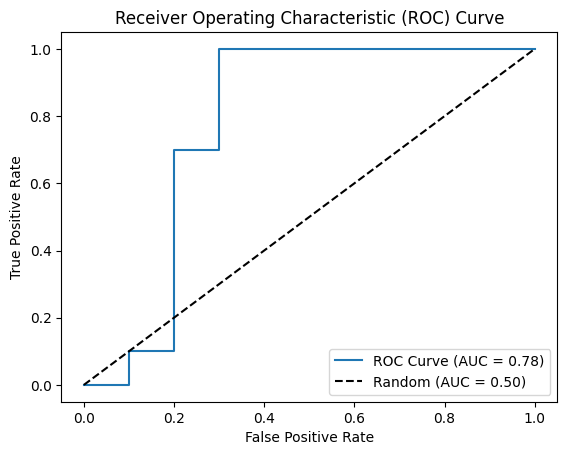

In [59]:
best_model_path = 'ckpts/contrastive/finetuning/ResNet18_finetuned_0.001.pth'
model = ResNetContrastive(ResBlock=Bottleneck, layer_list=[2, 2, 2, 2], num_channels=1, embedding_dim=128, num_classes=2, task='classification').to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_outputs = []
all_labels = []
with torch.no_grad():
    for batch in val_loader:
        inputs = batch[0].to(device)
        all_outputs.extend(model(inputs).cpu().numpy())
        all_labels.extend(batch[1].numpy())

all_outputs = [output[1] for output in all_outputs]

roc_auc = calculate_and_plot_roc_auc(all_outputs, all_labels)

# Solution 3

# Self Supervised Learning (SSL) approach: SimSiam network

In [13]:
train_dataset = LensingDataset(data_path, task='simsiam', split='train')
val_dataset = LensingDataset(data_path, task='simsiam', split='val')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=10)

In [14]:
train_dataset[0][0].shape

torch.Size([3, 334, 334])

In [15]:
def D(p, z, version='simplified'):
    """ 
    Negative cosine similarity.
    """
    if version == 'original':
        z = z.detach()
        p = F.normalize(p, dim=1)
        z = F.normalize(z, dim=1)
        return -(p*z).sum(dim=1).mean()
    elif version == 'simplified':
        return - F.cosine_similarity(p, z.detach(), dim=-1).mean()
    else:
        raise Exception


class projection_MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=2048, out_dim=2048):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.BatchNorm1d(hidden_dim),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x 


class prediction_MLP(nn.Module):
    def __init__(self, in_dim=2048, hidden_dim=512, out_dim=2048):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x 


class SimSiam(nn.Module):
    def __init__(self, backbone=resnet18()):
        super().__init__()

        self.backbone = backbone
        self.projector = projection_MLP(backbone.fc.out_features)

        self.predictor = prediction_MLP()
    
    def forward(self, x1, x2):
        z1 = self.projector(self.backbone(x1))
        z2 = self.projector(self.backbone(x2))
        p1 = self.predictor(z1)
        p2 = self.predictor(z2)
        L = D(p1, z2) / 2 + D(p2, z1) / 2
        return {'loss': L}

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimSiam().to(device)

batch = next(iter(train_loader))
image1, image2 = batch
image1 = image1.to(device)
image2 = image2.to(device)

outputs = model(image1, image2)
outputs

{'loss': tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)}

In [17]:
# Pretraining
def pretrain(model, train_loader, val_loader, num_epochs, lr, model_name, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    best_val_loss = 0.0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for img1, img2 in train_loader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            
            optimizer.zero_grad()
            output = model(img1, img2)
            loss = output['loss']
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

        if (epoch + 1) % 1 == 0:
            model.eval()
            running_loss = 0.0
            for img1, img2 in val_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)
                
                output = model(img1, img2)
                loss = output['loss']
                
                running_loss += loss.item()

            loss = running_loss / len(val_loader)
            if loss < best_val_loss:
                best_val_loss = loss
                torch.save(model.state_dict(), f'ckpts/SimSiam/pretraining/{model_name}_{lr}.pth')
            print(f"Validation Loss: {loss}")
        
# Fine-tuning
def finetune(model, train_dataloader, val_loader, num_epochs, num_classes, lr, model_name, device):
    in_features = model.backbone.fc.in_features
    model.backbone.fc = nn.Linear(in_features, num_classes)
    model = model.to(device)
    best_acc = 0.0
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    accuracy_metric = BinaryAccuracy().to(device)
    
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0
        
        for inputs, labels in train_dataloader:
            inputs = torch.cat([inputs, inputs, inputs], dim=1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model.backbone(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_acc += accuracy_metric(preds, labels)
        
        epoch_loss = running_loss / len(train_dataloader)
        epoch_acc = running_acc / len(train_dataloader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        if (epoch + 1) % 1 == 0:
            model.eval()
            running_loss = 0.0
            running_acc = 0.0
            for inputs, labels in val_loader:
                inputs = torch.cat([inputs, inputs, inputs], dim=1)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model.backbone(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels.long())
                
                running_loss += loss.item()
                running_acc += accuracy_metric(preds, labels)
            
            loss = running_loss / len(val_loader)
            acc = running_acc / len(val_loader)

            if acc > best_acc:
                best_acc = acc
                torch.save(model.state_dict(), f'ckpts/SimSiam/finetuning/{model_name}_{lr}.pth')

            print(f"Validation Loss: {loss:.4f}, Acc: {acc:.4f}")

### The loss function used for self supervised pretraining is negative cosine similarity (this was used by the original SimSiam paper: [Paper link](https://arxiv.org/pdf/2011.10566.pdf)). The more negative the loss is, the better it is. Best value is -1 and worst value is +1

In [18]:
model_name = 'ResNet18_SimSiam_pretrained'
lr = 0.001
model = SimSiam().to(device)
pretrain(model, train_loader, val_loader, num_epochs=20, model_name=model_name, lr=lr, device=device)

Epoch [1/20], Loss: -0.23929830592125653
Validation Loss: 0.8626854022343954
Epoch [2/20], Loss: -0.1862212949246168
Validation Loss: -0.8448212941487631
Epoch [3/20], Loss: -0.9522739171981811
Validation Loss: -0.9919859170913696
Epoch [4/20], Loss: -0.9970844411849975
Validation Loss: -0.9994796713193258
Epoch [5/20], Loss: -0.9998217058181763
Validation Loss: -0.9999681909879049
Epoch [6/20], Loss: -0.9999871802330017
Validation Loss: -0.9999970197677612
Epoch [7/20], Loss: -0.9999989533424377
Validation Loss: -0.9999998013178507
Epoch [8/20], Loss: -0.999999930858612
Validation Loss: -1.0
Epoch [9/20], Loss: -0.9999999976158143
Validation Loss: -1.0
Epoch [10/20], Loss: -1.0
Validation Loss: -1.0
Epoch [11/20], Loss: -1.0
Validation Loss: -1.0
Epoch [12/20], Loss: -1.0
Validation Loss: -1.0
Epoch [13/20], Loss: -1.0
Validation Loss: -1.0
Epoch [14/20], Loss: -1.0
Validation Loss: -1.0
Epoch [15/20], Loss: -1.0
Validation Loss: -1.0
Epoch [16/20], Loss: -1.0
Validation Loss: -1.0
Ep

In [ ]:
pretrained_state_dict = torch.load(f'ckpts/SimSiam/pretraining/{model_name}_{lr}.pth')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimSiam(backbone=resnet18()).to(device)
model.load_state_dict(pretrained_state_dict, strict=False)

train_dataset = LensingDataset(data_path, task='classification', split='train')
val_dataset = LensingDataset(data_path, task='classification', split='val')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=10)

model_name = 'ResNet18_SimSiam_finetuned'
finetune(model, train_loader, val_loader, num_epochs=50, num_classes=2, lr=0.1, model_name=model_name, device=device)

ROC AUC: 0.83


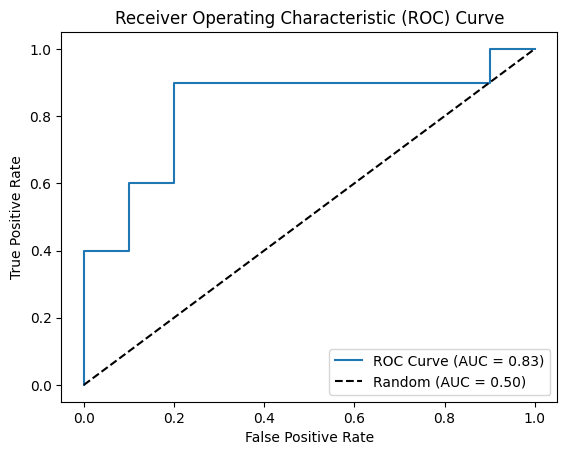

In [30]:
best_model_path = f'ckpts/SimSiam/finetuning/ResNet18_SimSiam_finetuned_0.1.pth'
model = SimSiam(backbone=resnet18())
in_features = model.backbone.fc.in_features
model.backbone.fc = nn.Linear(in_features, 2)
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)
model.eval()

all_outputs = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = torch.cat([inputs, inputs, inputs], dim=1)
        inputs = inputs.to(device)
        all_outputs.extend(model.backbone(inputs).cpu().numpy())
        all_labels.extend(labels.numpy())

all_outputs = [output[1] for output in all_outputs]

roc_auc = calculate_and_plot_roc_auc(all_outputs, all_labels)